# Example triangulation and 2D/3D evaluation

This notebook serves as an example to demonstrate: (1) single-sample evaluation of CNN 2D predictions, and (2) how to triangulate from 2 cameras to 3D space for 3D evaluation. It requires the generated .h5 files (accumulated frames and labels) from this repository.

In [13]:
import numpy as np
import keras.backend as K
from keras.models import load_model
import os
from os.path import join
import h5py
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
%matplotlib inline

### Change directories and parameters in the next cell

In [15]:
# home directory of the repository
homedir = '/Users/asudeaydin//Resilio Sync/DHP19/'
# Folder where .h5 files are generated, 346x260/
datadir = '/Users/asudeaydin/PycharmProjects/thesis/previous_work/DHP19/constant_count_frames/h5_dataset_7500_events/346x260'

# Selected recording
subj, sess, mov = 16, 2, 1
# Which image of the selected recording to use
imgidx = 24

In [16]:
P_mat_dir = join(homedir, 'P_matrices/')

# constant parameters
H = 260; W = 344; num_joints = 13

In [17]:
def decay_heatmap(heatmap, sigma2=4):
    heatmap = cv2.GaussianBlur(heatmap,(0,0),sigma2)
    heatmap /= np.max(heatmap) # keep the max to 1
    return heatmap

def mse2D(y_true, y_pred):
    mean_over_ch = K.mean(K.square(y_pred - y_true), axis=-1)
    mean_over_w = K.mean(mean_over_ch, axis=-1)
    mean_over_h = K.mean(mean_over_w, axis=-1)
    return mean_over_h

def get_2Dcoords_and_heatmaps_label(vicon_xyz, ch_idx):
    " From 3D label, get 2D label coordinates and heatmaps for selected camera "
    if ch_idx==1: P_mat_cam = np.load(join(P_mat_dir,'P1.npy'))
    elif ch_idx==3: P_mat_cam = np.load(join(P_mat_dir,'P2.npy'))
    elif ch_idx==2: P_mat_cam = np.load(join(P_mat_dir,'P3.npy'))
    elif ch_idx==0: P_mat_cam = np.load(join(P_mat_dir,'P4.npy'))

    # use homogeneous coordinates representation to project 3d XYZ coordinates to 2d UV pixel coordinates.
    vicon_xyz_homog = np.concatenate([vicon_xyz, np.ones([1,13])], axis=0)
    coord_pix_homog = np.matmul(P_mat_cam, vicon_xyz_homog)
    coord_pix_homog_norm = coord_pix_homog / coord_pix_homog[-1]
    u = coord_pix_homog_norm[0]
    v = H - coord_pix_homog_norm[1] # flip v coordinate to match the image direction

    # mask is used to make sure that pixel positions are in frame range.
    mask = np.ones(u.shape).astype(np.float32)
    mask[np.isnan(u)] = 0; mask[np.isnan(v)] = 0
    mask[u>W] = 0; mask[u<=0] = 0; mask[v>H] = 0; mask[v<=0] = 0

    # pixel coordinates
    u = u.astype(np.int32)
    v = v.astype(np.int32)
    
    # initialize, fill and smooth the heatmaps
    label_heatmaps = np.zeros((H, W, num_joints))
    for fmidx, zipd in enumerate(zip(v, u, mask)):
        if zipd[2]==1: # write joint position only when projection within frame boundaries
            label_heatmaps[zipd[0], zipd[1], fmidx] = 1
            label_heatmaps[:,:,fmidx] = decay_heatmap(label_heatmaps[:,:,fmidx])
    
    return np.stack((v,u), axis=-1), mask, label_heatmaps

def predict_CNN_extract_skeleton_2d(ch_idx, imgidx, verbose=False):
    """ Predict with CNN, extract predicted 2D coordinates, 
    and return image, 2D label and 2D prediction for imgidx sample """
    # Cropping rightmost pixels
    x_selected = x_h5['DVS'][imgidx:imgidx+1,:,:344, ch_idx]
    pred = trained_model.predict(np.expand_dims(x_selected, axis=-1))
    y_2d, gt_mask, y_heatmaps = get_2Dcoords_and_heatmaps_label(y_h5['XYZ'][imgidx], ch_idx)
    p_coords_max = np.zeros(y_2d.shape)
    confidence = np.zeros(y_2d.shape[0]) # confidence is not used in this example.
    
    for j_idx in range(y_2d.shape[0]):
        pred_j_map = pred[0,:,:,j_idx]
        # Predicted max value for each heatmap. Keep only the first one if more are present.
        p_coords_max_tmp = np.argwhere(pred_j_map == np.max(pred_j_map))
        p_coords_max[j_idx] = p_coords_max_tmp[0]
        # Confidence of the joint
        confidence[j_idx] = np.max(pred_j_map)
        if verbose:
            print('j{} GT: {} -- PRED: {} (mask: {})'.format(j_idx, y_2d[j_idx], p_coords_max[j_idx], gt_mask[j_idx]))
    y_2d_float = y_2d.astype(np.float)
    # where mask is 0, set gt back to NaN
    y_2d_float[gt_mask==0] = np.nan
    dist_2d = np.linalg.norm((y_2d_float - p_coords_max), axis=-1)
    mpjpe = np.nanmean(dist_2d)
    print('sample mpjpe: {}'.format(mpjpe))
    return x_selected[0], y_2d_float, p_coords_max

def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

# For 3D triangulation and plot:

def project_uv_xyz_cam(uv, M):
    # adapted from: https://www.cc.gatech.edu/~hays/compvision/proj3/
    N = len(uv)
    uv_homog = np.hstack((uv, np.ones((N, 1))))
    M_inv= np.linalg.pinv(M)
    xyz = np.dot(M_inv, uv_homog.T).T
    x = xyz[:, 0] / xyz[:, 3]; y = xyz[:, 1] / xyz[:, 3]; z = xyz[:, 2] / xyz[:, 3]
    return x,y,z

def find_intersection(P0,P1):
    # from: https://stackoverflow.com/questions/52088966/nearest-intersection-point-to-many-lines-in-python/52089867
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf."""

    # generate all line direction vectors 
    n = (P1-P0) / np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized
    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    # see fig. 1 

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (np.matmul(projs,P0[:,:,np.newaxis])).sum(axis=0)
    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q, rcond=None)[0]
    return p.T

def skeleton(x,y,z):
    " Definition of skeleton edges "
    # rename joints to identify name and axis
    x_head, x_shoulderR, x_shoulderL, x_elbowR, x_elbowL, x_hipR, x_hipL, \
    x_handR, x_handL, x_kneeR, x_kneeL, x_footR, x_footL = x[0], x[1], x[2], x[3], \
    x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12]
    y_head, y_shoulderR, y_shoulderL, y_elbowR, y_elbowL, y_hipR, y_hipL, \
    y_handR, y_handL, y_kneeR, y_kneeL, y_footR, y_footL = y[0], y[1], y[2], y[3], \
    y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12]
    z_head, z_shoulderR, z_shoulderL, z_elbowR, z_elbowL, z_hipR, z_hipL, \
    z_handR, z_handL, z_kneeR, z_kneeL, z_footR, z_footL = z[0], z[1], z[2], z[3],\
    z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12]
    #definition of the lines of the skeleton graph
    skeleton=np.zeros((14,3,2))
    skeleton[0,:,:]=[[x_head,x_shoulderR],[y_head,y_shoulderR],[z_head,z_shoulderR]]
    skeleton[1,:,:]=[[x_head,x_shoulderL],[y_head,y_shoulderL],[z_head,z_shoulderL]]
    skeleton[2,:,:]=[[x_elbowR,x_shoulderR],[y_elbowR,y_shoulderR],[z_elbowR,z_shoulderR]]
    skeleton[3,:,:]=[[x_elbowL,x_shoulderL],[y_elbowL,y_shoulderL],[z_elbowL,z_shoulderL]]
    skeleton[4,:,:]=[[x_elbowR,x_handR],[y_elbowR,y_handR],[z_elbowR,z_handR]]
    skeleton[5,:,:]=[[x_elbowL,x_handL],[y_elbowL,y_handL],[z_elbowL,z_handL]]
    skeleton[6,:,:]=[[x_hipR,x_shoulderR],[y_hipR,y_shoulderR],[z_hipR,z_shoulderR]]
    skeleton[7,:,:]=[[x_hipL,x_shoulderL],[y_hipL,y_shoulderL],[z_hipL,z_shoulderL]]
    skeleton[8,:,:]=[[x_hipR,x_kneeR],[y_hipR,y_kneeR],[z_hipR,z_kneeR]]
    skeleton[9,:,:]=[[x_hipL,x_kneeL],[y_hipL,y_kneeL],[z_hipL,z_kneeL]]
    skeleton[10,:,:]=[[x_footR,x_kneeR],[y_footR,y_kneeR],[z_footR,z_kneeR]]
    skeleton[11,:,:]=[[x_footL,x_kneeL],[y_footL,y_kneeL],[z_footL,z_kneeL]]
    skeleton[12,:,:]=[[x_shoulderR,x_shoulderL],[y_shoulderR,y_shoulderL],[z_shoulderR,z_shoulderL]]
    skeleton[13,:,:]=[[x_hipR,x_hipL],[y_hipR,y_hipL],[z_hipR,z_hipL]]
    return skeleton

def plotSingle3Dframe(ax, y_true_pred, c='red', limits=[[-500,500],[-500,500],[0,1500]], plot_lines=True):
    " 3D plot of single frame. Can be both label or prediction "
    x = y_true_pred[:, 0]; y = y_true_pred[:, 1]; z = y_true_pred[:, 2]
    ax.scatter(x, y, z, zdir='z', s=20, c=c, marker='o', depthshade=True)
    #plot skeleton
    lines_skeleton=skeleton(x,y,z)
    if plot_lines:
        for l in range(len(lines_skeleton)):
            ax.plot(lines_skeleton[l,0,:],lines_skeleton[l,1,:],lines_skeleton[l,2,:], c)
  
    ax.set_xlabel('X Label'); ax.set_ylabel('Y Label'); ax.set_zlabel('Z Label'); ax.set_aspect('auto')
    #set same scale for all the axis
    x_limits=limits[0]; y_limits=limits[1]; z_limits=limits[2]
    x_range = np.abs(x_limits[1] - x_limits[0]); x_middle = np.mean(x_limits)
    y_range = np.abs(y_limits[1] - y_limits[0]); y_middle = np.mean(y_limits)
    z_range = np.abs(z_limits[1] - z_limits[0]); z_middle = np.mean(z_limits)
    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*np.max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

### Load camera matrices, camera centers, input and label files, and import CNN model

In [18]:
P_mat_cam1 = np.load(join(P_mat_dir,'P1.npy'))
P_mat_cam2 = np.load(join(P_mat_dir,'P2.npy'))
P_mat_cam3 = np.load(join(P_mat_dir,'P3.npy'))
P_mat_cam4 = np.load(join(P_mat_dir,'P4.npy'))
P_mats = [P_mat_cam1, P_mat_cam2, P_mat_cam3, P_mat_cam4]
cameras_pos = np.load(join(P_mat_dir,'camera_positions.npy'))

# Load input and 3D label .h5 files
datafile = 'S9_session2_mov4_7500events'.format(subj, sess, mov)
path_x = join(datadir,datafile+'.h5')
path_y = join(datadir,datafile+'_label.h5')
x_h5 = h5py.File(path_x, 'r') 
y_h5 = h5py.File(path_y, 'r')

# Import model
modeldir='/Users/asudeaydin/PycharmProjects/thesis/previous_work/DHP19/'
trained_model=load_model(join(modeldir,'DHP_CNN.model'), custom_objects={'mse2D': mse2D})

### Calculate 2D prediction, calculate 2D MPJPE, and plot 2D results

In [19]:
# gt_2d_cam  : used only to plot in 2D.
# pred_2d_cam: used for 2D and 3D.
img_cam2, gt_2d_cam2, pred_2d_cam2 = predict_CNN_extract_skeleton_2d(3, imgidx, verbose=True)
img_cam3, gt_2d_cam3, pred_2d_cam3 = predict_CNN_extract_skeleton_2d(2, imgidx, verbose=True)

j0 GT: [ 50 172] -- PRED: [ 50. 172.] (mask: 1.0)
j1 GT: [ 70 162] -- PRED: [ 72. 161.] (mask: 1.0)
j2 GT: [ 70 193] -- PRED: [ 70. 194.] (mask: 1.0)
j3 GT: [ 96 165] -- PRED: [ 96. 165.] (mask: 1.0)
j4 GT: [ 99 202] -- PRED: [101. 202.] (mask: 1.0)
j5 GT: [109 165] -- PRED: [109. 164.] (mask: 1.0)
j6 GT: [112 184] -- PRED: [113. 184.] (mask: 1.0)
j7 GT: [120 151] -- PRED: [120. 150.] (mask: 1.0)
j8 GT: [126 194] -- PRED: [129. 194.] (mask: 1.0)
j9 GT: [151 163] -- PRED: [153. 163.] (mask: 1.0)
j10 GT: [158 184] -- PRED: [161. 185.] (mask: 1.0)
j11 GT: [193 159] -- PRED: [193. 159.] (mask: 1.0)
j12 GT: [204 193] -- PRED: [204. 194.] (mask: 1.0)
sample mpjpe: 1.3383342798206284


/opt/anaconda3/envs/dhp19/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


j0 GT: [ 44 148] -- PRED: [ 44. 148.] (mask: 1.0)
j1 GT: [ 71 128] -- PRED: [ 72. 126.] (mask: 1.0)
j2 GT: [ 62 153] -- PRED: [ 64. 155.] (mask: 1.0)
j3 GT: [100 121] -- PRED: [100. 122.] (mask: 1.0)
j4 GT: [ 88 153] -- PRED: [ 88. 152.] (mask: 1.0)
j5 GT: [108 143] -- PRED: [110. 141.] (mask: 1.0)
j6 GT: [103 158] -- PRED: [101. 157.] (mask: 1.0)
j7 GT: [126 136] -- PRED: [127. 136.] (mask: 1.0)
j8 GT: [110 171] -- PRED: [110. 172.] (mask: 1.0)
j9 GT: [153 144] -- PRED: [153. 144.] (mask: 1.0)
j10 GT: [145 163] -- PRED: [145. 163.] (mask: 1.0)
j11 GT: [199 143] -- PRED: [199. 142.] (mask: 1.0)
j12 GT: [180 174] -- PRED: [181. 175.] (mask: 1.0)
sample mpjpe: 1.2725541359126966


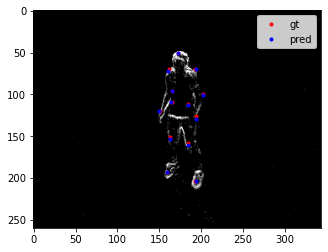

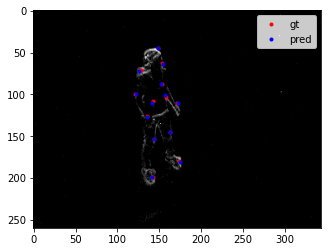

In [20]:
plot_2d(img_cam2, gt_2d_cam2, pred_2d_cam2)
plot_2d(img_cam3, gt_2d_cam3, pred_2d_cam3)

## From here: triangulation

In [21]:
# centers of the 2 used cameras
Point0 = (np.stack((cameras_pos[1],cameras_pos[2])))
# 3D label
label_3d = y_h5['XYZ'][imgidx].T
print(label_3d)
# initialize empty sample of 3D prediction
pred_3d = np.zeros(label_3d.shape)

[[  25.50146103  178.54788208 1695.27978516]
 [-175.88102722  260.90518188 1477.77478027]
 [ 180.22003174  301.93429565 1494.21960449]
 [-226.75627136  356.52734375 1190.7520752 ]
 [ 225.55809021  394.71661377 1204.34204102]
 [ -94.42044067  200.1857605  1100.90270996]
 [ 134.78771973  231.95277405 1093.97802734]
 [-239.90556335  147.06373596  972.94500732]
 [ 282.89916992  191.76765442  984.24072266]
 [-133.79011536  212.60438538  631.81964111]
 [ 148.82244873  216.5166626   613.87792969]
 [-211.76872253  214.5552063   117.24368286]
 [ 269.60418701  212.63615417  135.07624817]]


### Adapt the 2D prediction to match the same format of 3D label after back projection

In [22]:
pred_2d_cam2_ = np.zeros(pred_2d_cam2.shape)
pred_2d_cam3_ = np.zeros(pred_2d_cam3.shape)

pred_2d_cam2_[:,0] = pred_2d_cam2[:,1]
pred_2d_cam2_[:,1] = H - pred_2d_cam2[:,0]

pred_2d_cam3_[:,0] = pred_2d_cam3[:,1]
pred_2d_cam3_[:,1] = H - pred_2d_cam3[:,0]

### Back project each 2D point to 3D space, and find intersection of rays using least squares

In [23]:
x_cam2_pred, y_cam2_pred, z_cam2_pred = project_uv_xyz_cam(pred_2d_cam2_, P_mat_cam2)
x_cam3_pred, y_cam3_pred, z_cam3_pred = project_uv_xyz_cam(pred_2d_cam3_, P_mat_cam3)

xyz_cam2 = np.stack((x_cam2_pred, y_cam2_pred, z_cam2_pred), axis=1)
xyz_cam3 = np.stack((x_cam3_pred, y_cam3_pred, z_cam3_pred), axis=1)

for joint_idx in range(13):
    # coordinates for both cameras of 2nd point of triangulation line.
    Point1 = np.stack((xyz_cam2[joint_idx,:], xyz_cam3[joint_idx,:]), axis=1).T
    intersection = find_intersection(Point0, Point1)
    pred_3d[joint_idx] = intersection[0]

### plot and calculate 3D MPJPE (in mm)

sample 3D mpjpe [mm]: 12.451429161149017


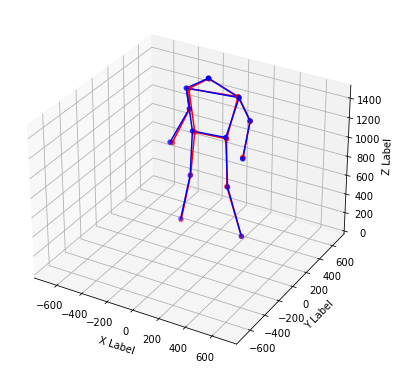

In [24]:
fs=5
fig = plt.figure(figsize=(fs,fs))
ax = Axes3D(fig)
# ax.set_aspect('auto')
plotSingle3Dframe(ax, label_3d, c='red') # gt
plotSingle3Dframe(ax, pred_3d, c='blue') # pred

mpjpe_3d_joints = np.linalg.norm((label_3d - pred_3d), axis=-1)
mpjpe_3d_sample = np.mean(mpjpe_3d_joints)
print('sample 3D mpjpe [mm]: {}'.format(mpjpe_3d_sample))